##### 2.5. Predicting Apartment Prices in Mexico City 🇲🇽

In [1]:
# Import libraries here
import warnings
# Import libraries here
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

Prepare Data

Import

Task 2.5.1: Write a wrangle function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City ("Distrito Federal") that cost less than $100,000.

2. Remove outliers by trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2".

3. Create separate "lat" and "lon" columns.

4. Mexico City is divided into 15 boroughs. Create a "borough" feature from the "place_with_parent_names" column.

5. Drop columns that are more than 50% null values.

6.Drop columns containing low- or high-cardinality categorical values.

7. Drop any columns that would constitute leakage for the target "price_aprox_usd".

8. Drop any columns that would create issues of multicollinearity.

Tip: Don't try to satisfy all the criteria in the first version of your wrangle function. Instead, work iteratively. Start with the first criteria, test it out with one of the Mexico CSV files in the data/ directory. Then add the next criteria.

In [3]:
# Build your `wrangle` function
import pandas as pd

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath, encoding="latin1")
    
    # Filter data: Apartments in "Distrito Federal" and price less than $100,000
    mask_location = df["place_with_parent_names"].str.contains("Distrito Federal", na=False)
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_location & mask_apt & mask_price]
    
        # Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    df = df[df["surface_covered_in_m2"].between(low, high)]

    # Create "lat" and "lon" columns from "lat-lon"
    if "lat-lon" in df.columns:
        df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
        df.drop(columns="lat-lon", inplace=True)

    # Create "borough" from "place_with_parent_names"
    df["borough"] = df["place_with_parent_names"].str.split("|").str[1].str.strip()
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop columns with more than 50% null values
    null_threshold = len(df) * 0.5
    df = df.loc[:, df.isnull().sum() <= null_threshold]

    # Drop low- and high-cardinality categorical columns
    cardinality = df.select_dtypes("object").nunique()
    low_cardinality = cardinality[cardinality < 2].index
    high_cardinality = cardinality[cardinality > 50].index
    df.drop(columns=list(low_cardinality) + list(high_cardinality), inplace=True)

    # Drop columns that are leaky for "price_aprox_usd"
    leaky_columns = [
        "price",
        "price_aprox_local_currency",
        "price_per_m2",
        "price_usd_per_m2",
    ]
    df.drop(columns=[col for col in leaky_columns if col in df.columns], inplace=True)

    # Drop columns with multicollinearity
    multicollinear_columns = ["surface_total_in_m2", "rooms"]
    df.drop(columns=[col for col in multicollinear_columns if col in df.columns], inplace=True)


    return df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1101 non-null   float64
 1   surface_covered_in_m2  1101 non-null   float64
 2   lat                    1041 non-null   float64
 3   lon                    1041 non-null   float64
 4   borough                1101 non-null   object 
dtypes: float64(4), object(1)
memory usage: 51.6+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito JuÃ¡rez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito JuÃ¡rez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,CoyoacÃ¡n
...,...,...,...,...,...
4596,73761.07,85.0,19.375733,-99.139518,Benito JuÃ¡rez
4597,32165.09,60.0,19.325608,-99.061120,Iztapalapa
4598,81664.04,90.0,19.441043,-99.175585,Miguel Hidalgo
4599,32770.99,50.0,19.442796,-99.154915,CuauhtÃ©moc


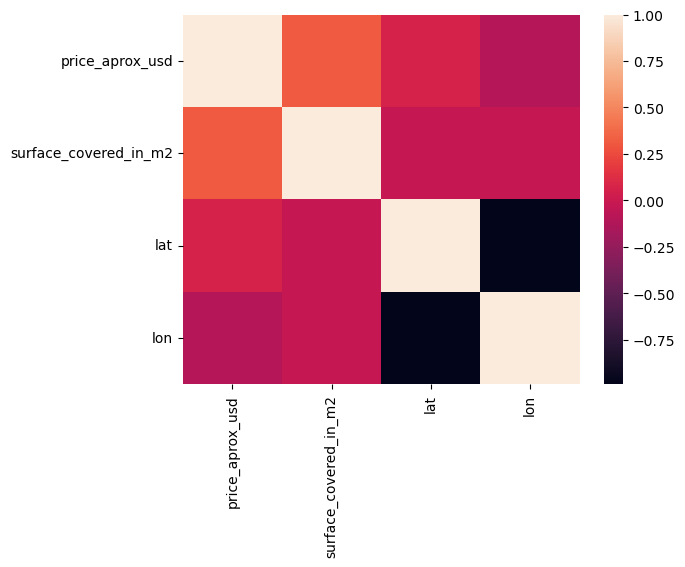

In [6]:
# Use this cell to test your wrangle function and explore the data
df = wrangle("datasets/mexico-city-real-estate-1.csv")
corr = df.select_dtypes("number").corr()
sns.heatmap(corr);
print(df.info())
df

Task 2.5.2: Use glob to create the list files. It should contain the filenames of all the Mexico City real estate CSVs in the ./data directory, except for mexico-city-test-features.csv.

In [7]:
files = glob("datasets/mexico-city-real-estate-*.csv")
files

['datasets\\mexico-city-real-estate-1.csv',
 'datasets\\mexico-city-real-estate-2.csv',
 'datasets\\mexico-city-real-estate-3.csv',
 'datasets\\mexico-city-real-estate-4.csv',
 'datasets\\mexico-city-real-estate-5.csv']

Task 2.5.3: Combine your wrangle function, a list comprehension, and pd.concat to create a DataFrame df. It should contain all the properties from the five CSVs in files.

In [8]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 11 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito JuÃ¡rez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito JuÃ¡rez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,CoyoacÃ¡n


Explore

Task 2.5.4: Create a histogram showing the distribution of apartment prices ("price_aprox_usd") in df. Be sure to label the x-axis "Price [$]", the y-axis "Count", and give it the title "Distribution of Apartment Prices". Use Matplotlib (plt).

What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

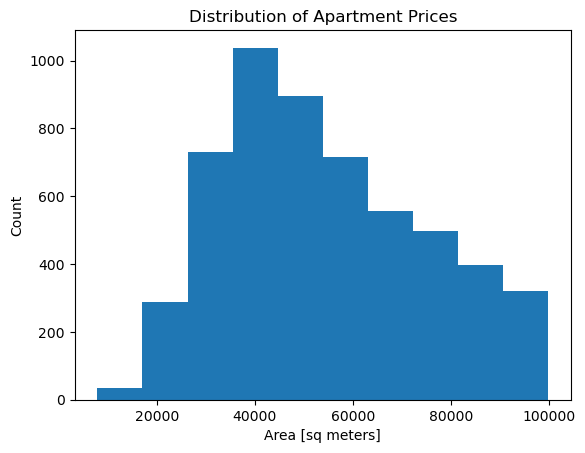

In [9]:
# Build histogram
plt.hist(df["price_aprox_usd"])

# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices");

Task 2.5.5: Create a scatter plot that shows apartment price ("price_aprox_usd") as a function of apartment size ("surface_covered_in_m2"). Be sure to label your x-axis "Area [sq meters]" and y-axis "Price [USD]". Your plot should have the title "Mexico City: Price vs. Area". Use Matplotlib (plt).

In [ ]:
# Build scatter plot
plt.scatter()


# Label axes


# Add title



In [10]:
# Check for cardinality
df.select_dtypes("object")

,borough
11,Benito JuÃ¡rez
20,Iztacalco
21,Benito JuÃ¡rez
22,Azcapotzalco
26,CoyoacÃ¡n
...,...
4595,Miguel Hidalgo
4599,Ãlvaro ObregÃ³n
4606,CuauhtÃ©moc
4616,Ãlvaro ObregÃ³n


In [11]:
df.select_dtypes("object").nunique()

borough    15
dtype: int64

Do you see a relationship between price and area in the data? How is this similar to or different from the Buenos Aires dataset?

Task 2.5.6: (UNGRADED) Create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color.

What areas of the city seem to have higher real estate prices?

In [ ]:
# Plot Mapbox location and price
fig = ...


fig.show()

In [12]:
# checking for leakage
sorted(df.columns)

['borough', 'lat', 'lon', 'price_aprox_usd', 'surface_covered_in_m2']

In [13]:
# checking for co-linearity in our features
corr = df.select_dtypes("number").drop(columns = ["price_aprox_usd"]).corr()
corr

,surface_covered_in_m2,lat,lon
surface_covered_in_m2,1.000000,-0.033695,-0.002994
lat,-0.033695,1.000000,-0.852599
lon,-0.002994,-0.852599,1.000000


Task 2.5.5: Create a scatter plot that shows apartment price ("price_aprox_usd") as a function of apartment size ("surface_covered_in_m2"). Be sure to label your x-axis "Area [sq meters]" and y-axis "Price [USD]". Your plot should have the title "Mexico City: Price vs. Area". Use Matplotlib (plt).

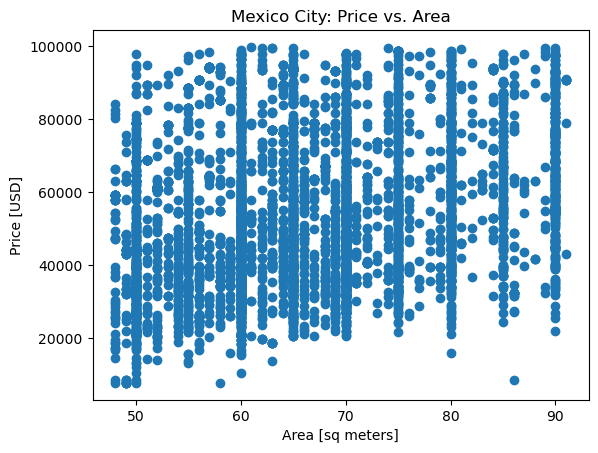

In [14]:
# Plot price vs area
plt.scatter(x = df["surface_covered_in_m2"], y = df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");

Do you see a relationship between price and area in the data? How is this similar to or different from the Buenos Aires dataset?

Task 2.5.6: (UNGRADED) Create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color.

What areas of the city seem to have higher real estate prices?

In [17]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,
    lat = "lat",
    lon = "lon",
    #center = {"lat": 19.6345, "lon": -99.5528},
    color = "price_aprox_usd",
    width = 900,
    height = 600,
    hover_data = ["borough", "surface_covered_in_m2", "price_aprox_usd"]
);

fig.update_layout(mapbox_style="open-street-map")
fig.show()

Split

Task 2.5.7: Create your feature matrix X_train and target vector y_train. Your target is "price_aprox_usd". Your features should be all the columns that remain in the DataFrame you cleaned above.

In [18]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
feature = []
for column in df.columns:
    if column != target:
        feature.append(column)
X_train = df[feature]
y_train = df[target]

Build Model

Baseline

Task 2.5.8: Calculate the baseline mean absolute error for your model.

In [19]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


Iterate

Task 2.5.9: Create a pipeline named model that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

In [20]:
# Build Model
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

Evaluate

Task 2.5.10: Read the CSV file mexico-city-test-features.csv into the DataFrame X_test.

Tip: Make sure the X_train you used to train your model has the same column order as X_test. Otherwise, it may hurt your model's performance.

In [21]:
X_test = pd.read_csv("datasets/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


Task 2.5.11: Use your model to generate a Series of predictions for X_test. When you submit your predictions to the grader, it will calculate the mean absolute error for your model.

In [22]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    49434.427368
2    34263.884179
3    53488.425607
4    54960.736004
dtype: float64

Communicate Results

Task 2.5.12: Create a Series named feat_imp. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.

In [23]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index = features)
feat_imp

surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito JuÃ¡rez            13778.188880
borough_Iztacalco                   405.403127
borough_Azcapotzalco               2459.288646
borough_CoyoacÃ¡n                  3737.561001
borough_Ãlvaro ObregÃ³n           3275.121061
borough_Iztapalapa               -13349.017448
borough_CuauhtÃ©moc                -350.531990
borough_TlÃ¡huac                 -14166.869486
borough_Miguel Hidalgo             1977.314718
borough_Venustiano Carranza       -5609.918629
borough_Tlalpan                   10319.429805
borough_Gustavo A. Madero         -6637.429757
borough_Xochimilco                  929.857400
borough_La Magdalena Contreras    -5925.666450
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

Task 2.5.13: Create a horizontal bar chart that shows the 10 most influential coefficients for your model. Be sure to label your x- and y-axis "Importance [USD]" and "Feature", respectively, and give your chart the title "Feature Importances for Apartment Price". Use pandas.

Text(0.5, 1.0, 'Feature Importance for Apartment Price')

c:\Users\Yahya\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning:

Glyph 129 (\x81) missing from current font.

c:\Users\Yahya\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 129 (\x81) missing from current font.



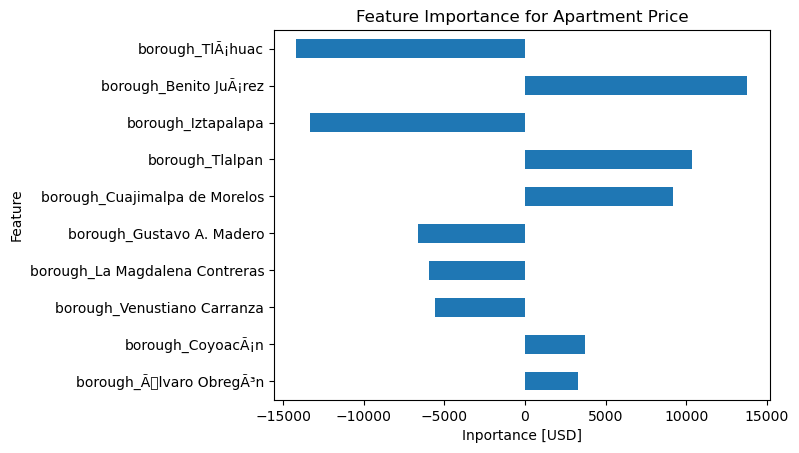

In [26]:
# Build bar chart
feat_imp.sort_values(key= abs).tail(10).plot(kind= "barh")

# Label axes
plt.xlabel("Inportance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importance for Apartment Price")

For this lesson, I relied on equations and visualizations for communication about my model. In many data science projects, however, communication means giving stakeholders tools they can use to deploy a model — in other words, use it in action. So let's look at two ways you might deploy this model.

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output.

Create a function predict_price that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.

In [27]:
def predict_price(area, lat, lon, borough):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "borough": borough
    }
    df = pd.DataFrame(data, index = [0])
    
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [28]:
## Example
predict_price(100, 18, -100, "Azcapotzalco")

'Predicted apartment price: $66468.88'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Let's create one using Jupyter Widgets.

In [29]:
interact(
    predict_price,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4531123034…